# Proyek Klasifikasi Gambar: [Animals-10]
- **Nama:** [M. Baihaqi Alza]
- **Email:** [baihaqialza1289@gmail.com]
- **ID Dicoding:** [bhqialza]

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip install -q kaggle tensorflowjs

import os
import zipfile
from google.colab import files
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Lambda
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
!mkdir -p ~/.kaggle
print("Unggah kaggle.json:")
uploaded = files.upload()
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API siap.")

Unggah kaggle.json:


Saving kaggle.json to kaggle.json
Kaggle API siap.


In [4]:
print("Mengunduh dataset Animals-10...")
!kaggle datasets download -d alessiocorrado99/animals10 --force
print("Selesai mengunduh Animals-10.")

local_zip_animals10 = '/content/animals10.zip'
tujuan_ekstrak_animals10 = '/content/animals-10-dataset'

if os.path.exists(tujuan_ekstrak_animals10):
    !rm -rf {tujuan_ekstrak_animals10}
os.makedirs(tujuan_ekstrak_animals10, exist_ok=True)

print(f"Mengekstrak {local_zip_animals10} ke {tujuan_ekstrak_animals10}...")
try:
    with zipfile.ZipFile(local_zip_animals10, 'r') as zip_ref:
        zip_ref.extractall(tujuan_ekstrak_animals10)
    print("Selesai mengekstrak Animals-10.")
except FileNotFoundError:
    print(f"ERROR: File {local_zip_animals10} tidak ditemukan. Periksa nama file hasil unduhan.")

dataset_source_dir = os.path.join(tujuan_ekstrak_animals10, 'raw-img')

print(f"Direktori sumber dataset Animals-10: {dataset_source_dir}")

if not os.path.exists(dataset_source_dir):
    print(f"ERROR: Direktori sumber dataset tidak ditemukan: {dataset_source_dir}")
else:
    print("Path dataset Animals-10 siap digunakan untuk data loading.")

Mengunduh dataset Animals-10...
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 98% 574M/586M [00:01<00:00, 215MB/s]
100% 586M/586M [00:01<00:00, 309MB/s]
Selesai mengunduh Animals-10.
Mengekstrak /content/animals10.zip ke /content/animals-10-dataset...
Selesai mengekstrak Animals-10.
Direktori sumber dataset Animals-10: /content/animals-10-dataset/raw-img
Path dataset Animals-10 siap digunakan untuk data loading.


## Data Preparation

### Data Loading

In [5]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

dataset_source_dir = '/content/animals-10-dataset/raw-img'

print(f"Memuat seluruh data dari direktori: {dataset_source_dir}...")
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_source_dir,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

class_names = full_dataset.class_names
num_classes = len(class_names)
print(f"\nNama Kelas yang Ditemukan: {class_names}")
print(f"Jumlah Kelas: {num_classes}")
print(f"Jumlah total file gambar yang ditemukan dalam dataset: {len(full_dataset.file_paths)}")
print(f"Jumlah total batch yang dimuat: {tf.data.experimental.cardinality(full_dataset).numpy()}")

Memuat seluruh data dari direktori: /content/animals-10-dataset/raw-img...
Found 26179 files belonging to 10 classes.

Nama Kelas yang Ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Jumlah Kelas: 10
Jumlah total file gambar yang ditemukan dalam dataset: 26179
Jumlah total batch yang dimuat: 819


### Data Preprocessing

#### Split Dataset

In [6]:
DATASET_SIZE_FULL = tf.data.experimental.cardinality(full_dataset).numpy()
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

train_batches = int(TRAIN_RATIO * DATASET_SIZE_FULL)
val_batches = int(VAL_RATIO * DATASET_SIZE_FULL)
# test_batches dihitung dari sisa

train_dataset = full_dataset.take(train_batches)
remaining_after_train = full_dataset.skip(train_batches)
validation_dataset = remaining_after_train.take(val_batches)
test_dataset_initial = remaining_after_train.skip(val_batches)

print(f"\n--- Informasi Pembagian Dataset Setelah Split ---")
print(f"Jumlah batch untuk train_dataset: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Jumlah batch untuk validation_dataset: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"Jumlah batch untuk test_dataset_initial: {tf.data.experimental.cardinality(test_dataset_initial).numpy()}")


--- Informasi Pembagian Dataset Setelah Split ---
Jumlah batch untuk train_dataset: 573
Jumlah batch untuk validation_dataset: 122
Jumlah batch untuk test_dataset_initial: 124


In [7]:
data_augmentation_layers = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.1),
    RandomContrast(0.1),
], name="data_augmentation_animals10")

AUTOTUNE = tf.data.AUTOTUNE

def prepare(dataset, augment=False, shuffle_during_prepare=False):
    prepared_ds = dataset.map(lambda x, y: (x, y), num_parallel_calls=AUTOTUNE)
    prepared_ds = prepared_ds.cache()
    if shuffle_during_prepare:
        buffer_size = tf.data.experimental.cardinality(dataset).numpy()
        if buffer_size == tf.data.experimental.UNKNOWN_CARDINALITY or buffer_size <= 0:
            buffer_size = 1000
        prepared_ds = prepared_ds.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    if augment:
        prepared_ds = prepared_ds.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return prepared_ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_dataset, augment=True, shuffle_during_prepare=True)
val_ds = prepare(validation_dataset, augment=False, shuffle_during_prepare=False)
test_ds = prepare(test_dataset_initial, augment=False, shuffle_during_prepare=False) # Pastikan ini dijalankan

print("\nDataset training, validasi, dan testing (Animals-10) sudah di-preprocess.")


Dataset training, validasi, dan testing (Animals-10) sudah di-preprocess.


In [8]:
class MobileNetV2PreprocessLayer(Layer):
    def __init__(self, **kwargs):
        super(MobileNetV2PreprocessLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return preprocess_input(inputs) # preprocess_input dari MobileNetV2

    def get_config(self): # Penting untuk menyimpan dan memuat
        config = super(MobileNetV2PreprocessLayer, self).get_config()
        return config

## Modelling

In [9]:
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model_hybrid_final = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MobileNetV2PreprocessLayer(name="mobilenet_preprocess_custom_layer"),

    base_model,

    # Layer Conv2D dan Pooling eksplisit untuk Kriteria 4
    Conv2D(64, (3, 3), activation='relu', padding='same', name="explicit_conv_1"),
    BatchNormalization(name="explicit_bn_1"),
    MaxPooling2D((2, 2), name="explicit_pool_1"),

    Conv2D(128, (3, 3), activation='relu', padding='same', name="explicit_conv_2"),
    BatchNormalization(name="explicit_bn_2"),
    MaxPooling2D((2, 2), name="explicit_pool_2"),

    GlobalAveragePooling2D(name="global_avg_pool"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_1"),
    Dense(num_classes, activation='softmax', name="output_layer")
], name="HybridModel_Animals10_Final")

model_hybrid_final.summary()
model = model_hybrid_final

<ipython-input-9-05bf2aea019c>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "HybridModel_Animals10_Final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_preprocess_custom_la… │ (None, 150, 150, 3)    │             0 │
│ (MobileNetV2PreprocessLayer)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_conv_1 (Conv2D)        │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_bn_1                   │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_pool_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_conv_2 (Conv2D)        │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_bn_2                   │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_pool_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,087,754 (11.78 MB)

 Trainable params: 829,386 (3.16 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

## Evaluasi dan Visualisasi

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Model hybrid final berhasil di-compile.")

Model hybrid final berhasil di-compile.


In [11]:
# Custom callback untuk stop training ketika akurasi mencapai target
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95, monitor='val_accuracy'):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is not None and current_accuracy >= self.threshold:
            print(f"\nReached {self.threshold*100}% {self.monitor}! Stopping training.")
            self.model.stop_training = True



In [12]:
best_model_path = "best_hybrid_animals10_final.keras"
callbacks_final = [
    EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=best_model_path, save_best_only=True, monitor='val_accuracy', verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=1)
]
print(f"Callbacks siap. Model terbaik akan disimpan di: {best_model_path}")

Callbacks siap. Model terbaik akan disimpan di: best_hybrid_animals10_final.keras


In [ ]:
EPOCHS_STAGE1 = 25

print("Memulai Training ...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks_final,
    verbose=1
)
print("\nTraining selesai!")

Memulai Training ...
Epoch 1/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.5214 - loss: 1.6184
Epoch 1: val_accuracy improved from -inf to 0.90523, saving model to best_hybrid_animals10_final.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 542s 893ms/step - accuracy: 0.5216 - loss: 1.6175 - val_accuracy: 0.9052 - val_loss: 0.3053 - learning_rate: 1.0000e-04
Epoch 2/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.7905 - loss: 0.6702
Epoch 2: val_accuracy improved from 0.90523 to 0.91368, saving model to best_hybrid_animals10_final.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 532s 877ms/step - accuracy: 0.7905 - loss: 0.6702 - val_accuracy: 0.9137 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 3/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.8245 - loss: 0.5603
Epoch 3: val_accuracy improved from 0.91368 to 0.92085, saving model to best_hybrid_animals10_final.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 536s 832ms/step - accuracy: 0.8245 - loss: 0.5603 - val_accuracy: 0.9209 

In [13]:
best_model_path = "best_hybrid_animals10_final.keras"

print(f"Memuat model terbaik dari: {best_model_path}...")
try:
    custom_objects_to_load = {'MobileNetV2PreprocessLayer': MobileNetV2PreprocessLayer}
    model_terbaik = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects_to_load)

    print("Model terbaik berhasil dimuat.")
    model_terbaik.summary()
except FileNotFoundError:
    print(f"ERROR: File model tidak ditemukan di path: {best_model_path}")
    print("Pastikan nama file dan path sudah benar.")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    print("Pastikan definisi custom layer 'MobileNetV2PreprocessLayer' sudah benar dan dieksekusi, serta didaftarkan di custom_objects.")

Memuat model terbaik dari: best_hybrid_animals10_final.keras...
Model terbaik berhasil dimuat.


Model: "HybridModel_Animals10_Final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_preprocess_custom_la… │ (None, 150, 150, 3)    │             0 │
│ (MobileNetV2PreprocessLayer)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_conv_1 (Conv2D)        │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_bn_1                   │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_pool_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_conv_2 (Conv2D)        │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_bn_2                   │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ explicit_pool_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,746,528 (18.11 MB)

 Trainable params: 829,386 (3.16 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

 Optimizer params: 1,658,774 (6.33 MB)

In [14]:

print("\nMengevaluasi model terbaik pada test dataset...")
try:
    test_loss, test_accuracy = model_terbaik.evaluate(test_ds, verbose=1)

    print(f"\n=== HASIL EVALUASI TEST DATASET ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    if test_accuracy >= 0.85:
        print("\n Akurasi Test Set sudah memenuhi kriteria minimal (85%).")
        if test_accuracy >= 0.95:
            print(" Akurasi Test Set mencapai target bintang 5 (95%)!")
    else:
        print(f"\n Akurasi Test Set ({test_accuracy*100:.2f}%) masih di bawah 85%.")

except NameError as ne:
    print(f"ERROR NameError: {ne}")
    print("Pastikan variabel sudah terdefinisi.")
except Exception as e:
    print(f"Terjadi kesalahan lain saat evaluasi: {e}")


Mengevaluasi model terbaik pada test dataset...
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.9403 - loss: 0.2052

=== HASIL EVALUASI TEST DATASET ===
Test Loss: 0.2060
Test Accuracy: 93.86%

 Akurasi Test Set sudah memenuhi kriteria minimal (85%).


In [15]:
# Prediksi pada test dataset
print("Making predictions on test dataset...")
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan true labels
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

print(f"Total test samples: {len(true_labels)}")
print(f"Predictions shape: {predictions.shape}")

Making predictions on test dataset...
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step
Total test samples: 3939
Predictions shape: (3939, 10)


In [16]:
# Classification report
print("\n=== CLASSIFICATION REPORT ===")
report = classification_report(
    true_labels,
    predicted_classes,
    target_names=class_names,
    digits=4
)
print(report)

# Akurasi per kelas
print("\n=== AKURASI PER KELAS ===")
for i, class_name in enumerate(class_names):
    class_mask = true_labels == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(predicted_classes[class_mask] == true_labels[class_mask])
        print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        cane     0.0000    0.0000    0.0000       716
     cavallo     0.0000    0.0000    0.0000       407
    elefante     0.0000    0.0000    0.0000       198
    farfalla     0.0000    0.0000    0.0000       326
     gallina     0.0000    0.0000    0.0000       449
       gatto     0.0000    0.0000    0.0000       244
       mucca     0.0000    0.0000    0.0000       307
      pecora     0.0762    0.9828    0.1414       291
       ragno     0.1758    0.0439    0.0703       729
  scoiattolo     0.0000    0.0000    0.0000       272

    accuracy                         0.0807      3939
   macro avg     0.0252    0.1027    0.0212      3939
weighted avg     0.0382    0.0807    0.0234      3939


=== AKURASI PER KELAS ===
cane: 0.0000 (0.00%)
cavallo: 0.0000 (0.00%)
elefante: 0.0000 (0.00%)
farfalla: 0.0000 (0.00%)
gallina: 0.0000 (0.00%)
gatto: 0.0000 (0.00%)
mucca: 0.0000 (0.00%)
pecora: 0.9828 (98.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


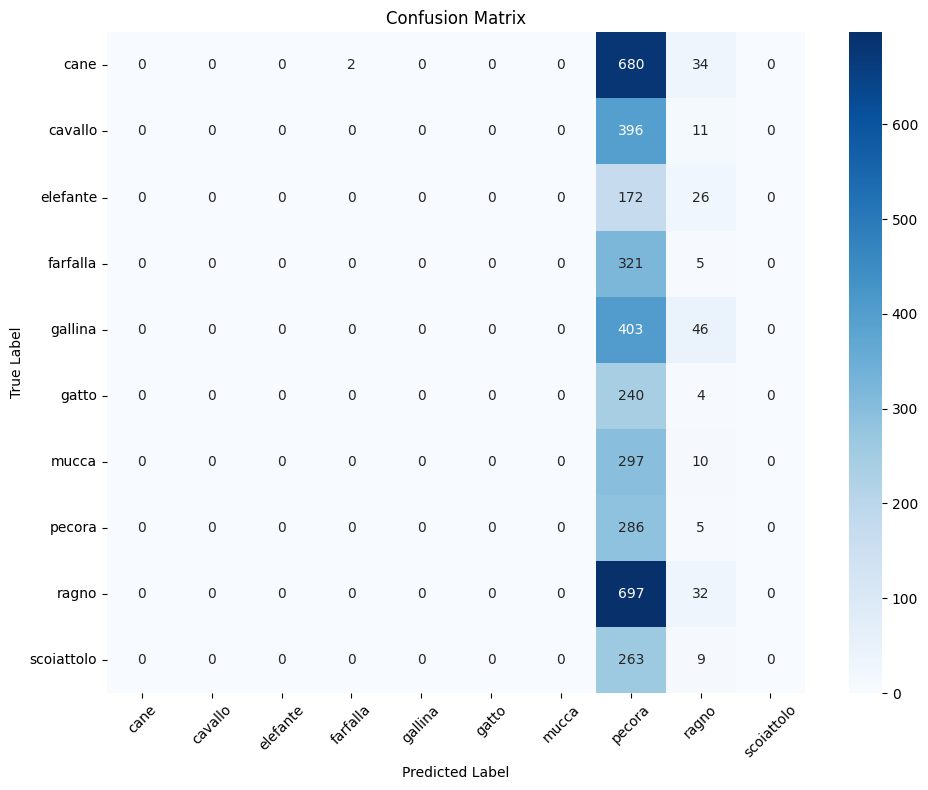

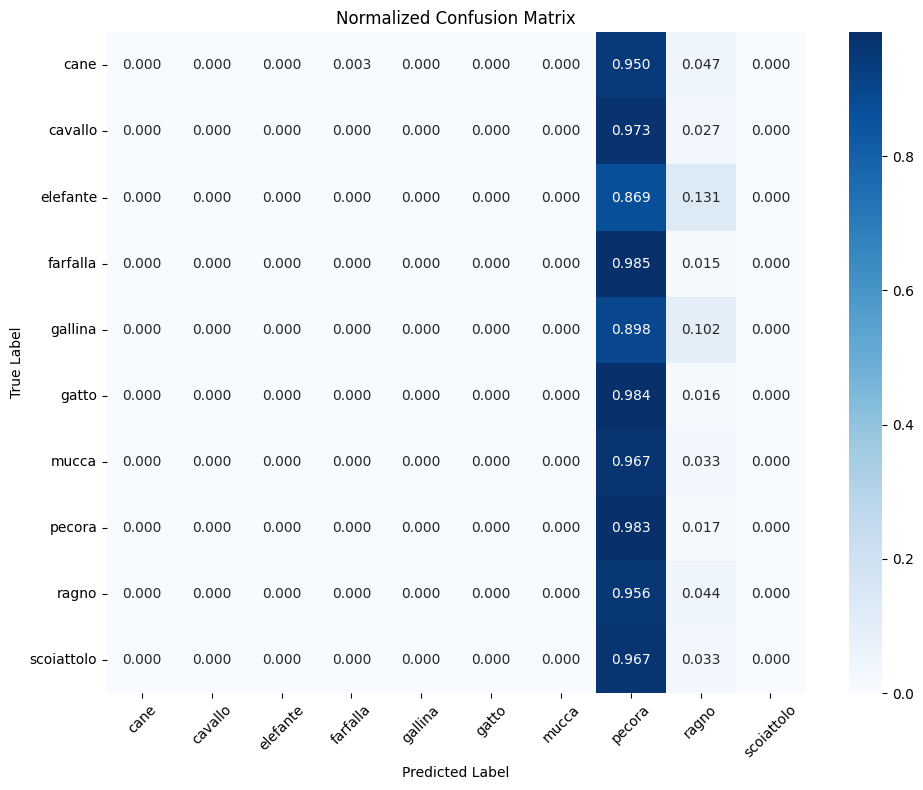

In [17]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

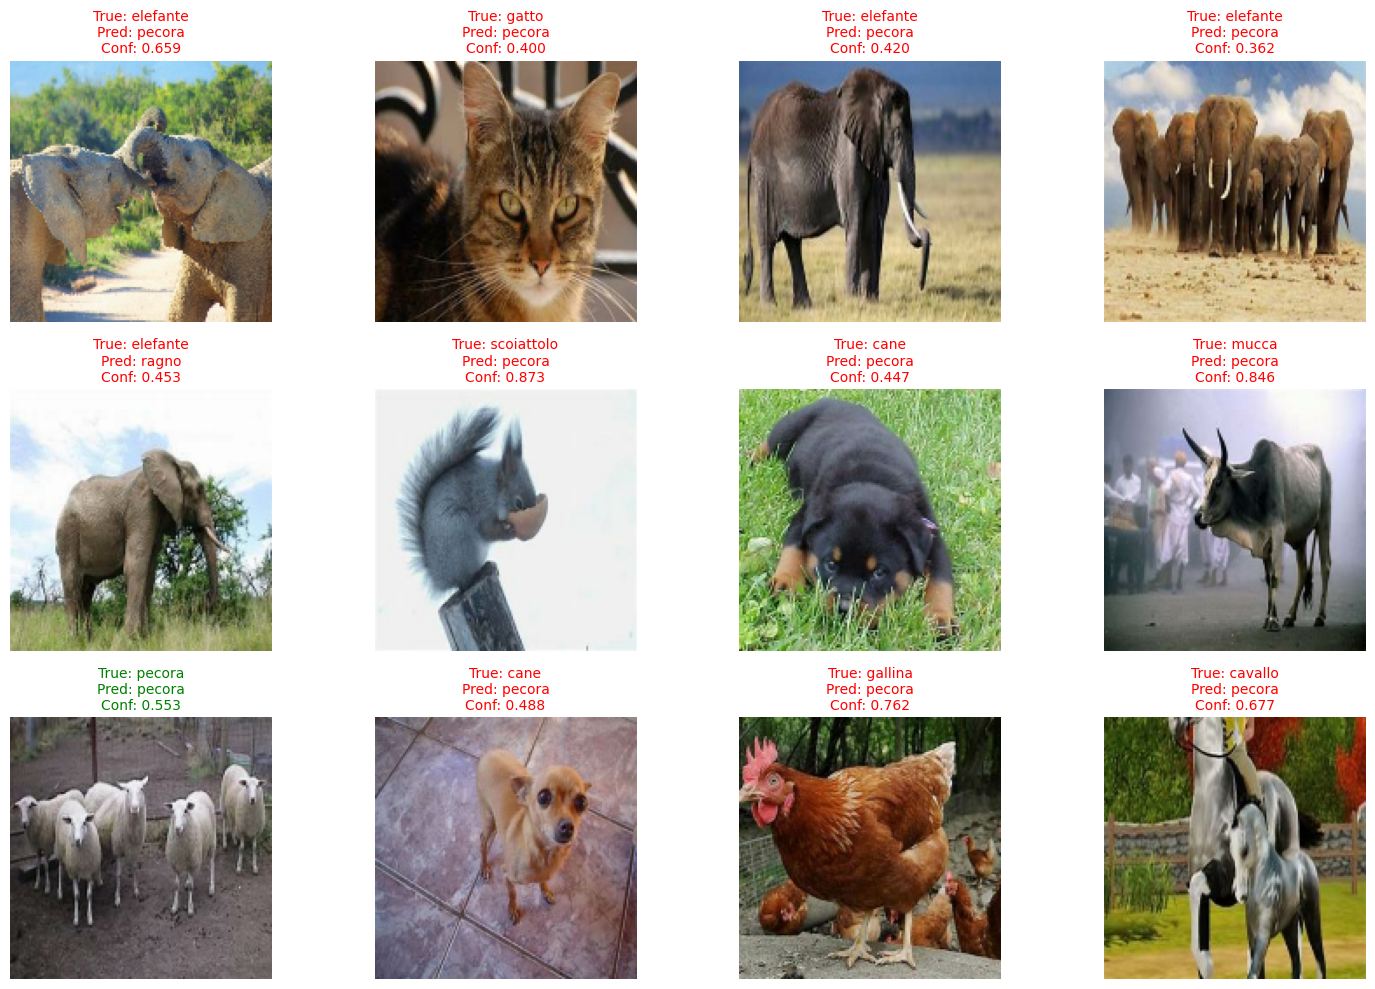

In [18]:
# Fungsi untuk menampilkan prediksi sample
def plot_predictions(dataset, num_samples=12):
    plt.figure(figsize=(15, 10))

    # Ambil batch pertama
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 4, i + 1)

            # Tampilkan gambar
            img = images[i].numpy().astype("uint8")
            plt.imshow(img)

            # Prediksi
            img_array = tf.expand_dims(images[i], 0)
            prediction = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction[0])
            confidence = np.max(prediction[0])

            # True label
            true_class = labels[i].numpy()

            # Warna: hijau jika benar, merah jika salah
            color = 'green' if predicted_class == true_class else 'red'

            plt.title(f'True: {class_names[true_class]}\n'
                     f'Pred: {class_names[predicted_class]}\n'
                     f'Conf: {confidence:.3f}',
                     color=color, fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan prediksi sample
plot_predictions(test_ds, num_samples=12)

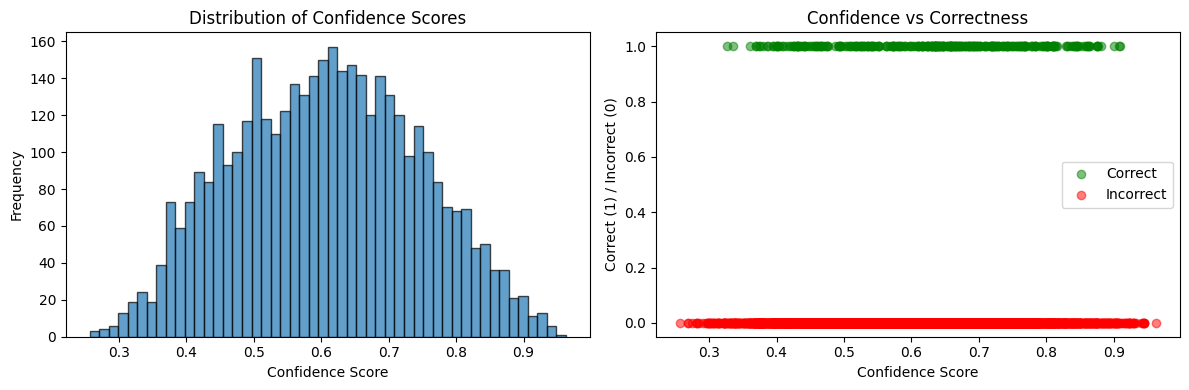

Average confidence score: 0.6064
Confidence score for correct predictions: 0.6361
Confidence score for incorrect predictions: 0.6037


In [19]:
# Analisis confidence scores
confidence_scores = np.max(predictions, axis=1)

plt.figure(figsize=(12, 4))

# Histogram confidence scores
plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Confidence vs Accuracy
plt.subplot(1, 2, 2)
correct_predictions = (predicted_classes == true_labels)
plt.scatter(confidence_scores[correct_predictions],
           np.ones(np.sum(correct_predictions)),
           alpha=0.5, label='Correct', color='green')
plt.scatter(confidence_scores[~correct_predictions],
           np.zeros(np.sum(~correct_predictions)),
           alpha=0.5, label='Incorrect', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Correct (1) / Incorrect (0)')
plt.title('Confidence vs Correctness')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average confidence score: {np.mean(confidence_scores):.4f}")
print(f"Confidence score for correct predictions: {np.mean(confidence_scores[correct_predictions]):.4f}")
print(f"Confidence score for incorrect predictions: {np.mean(confidence_scores[~correct_predictions]):.4f}")

Total incorrect predictions: 3621


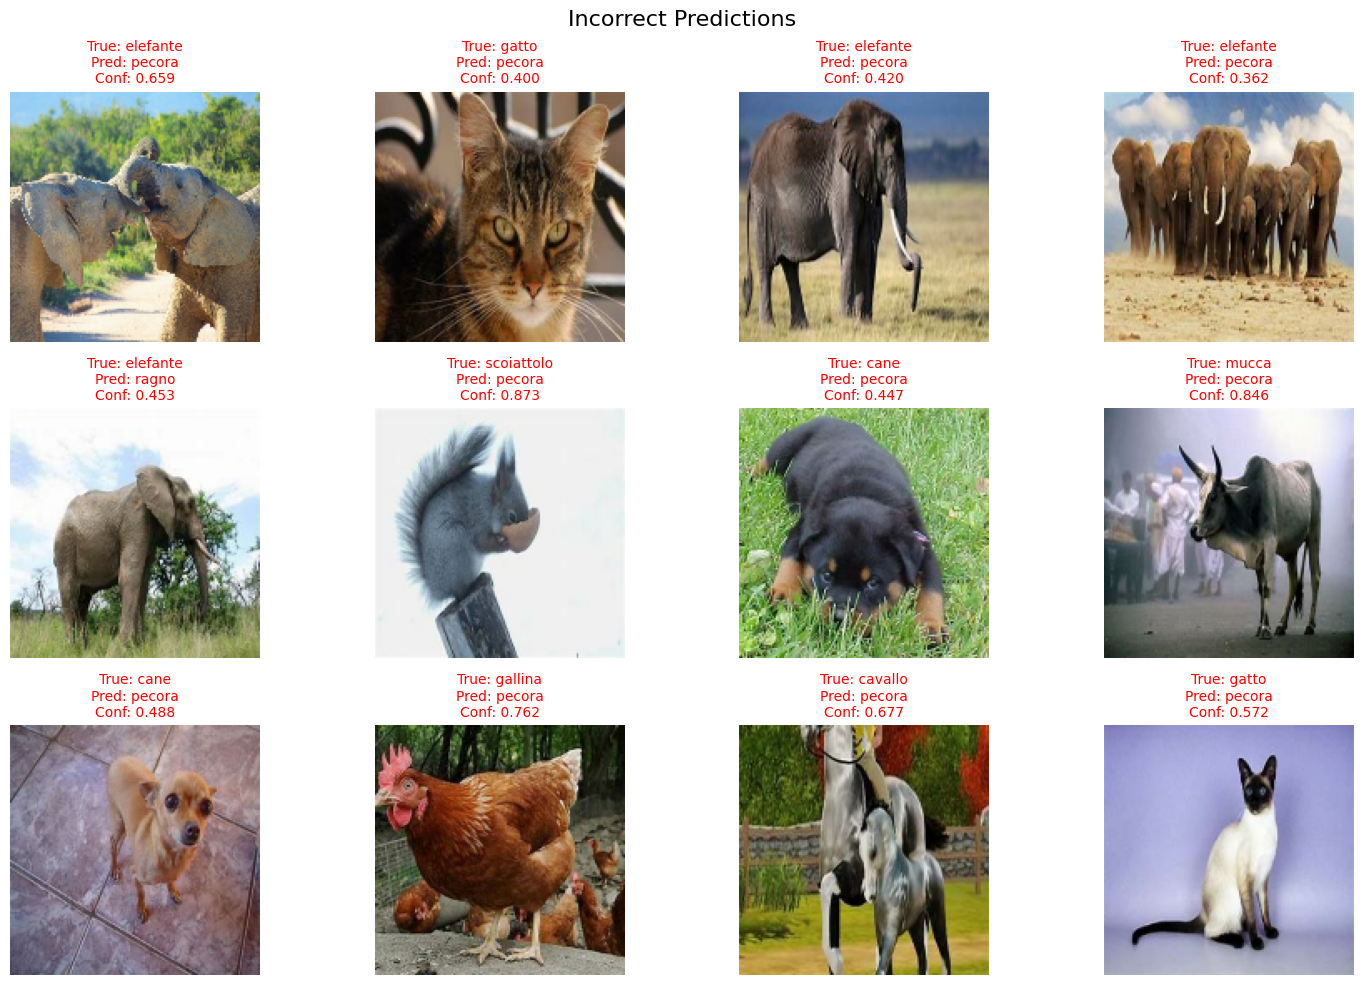

In [20]:
# Analisis prediksi yang salah
incorrect_indices = np.where(predicted_classes != true_labels)[0]
print(f"Total incorrect predictions: {len(incorrect_indices)}")

if len(incorrect_indices) > 0:
    # Tampilkan beberapa prediksi yang salah
    plt.figure(figsize=(15, 10))

    num_errors_to_show = min(12, len(incorrect_indices))

    # Ambil semua gambar dan label dari test dataset
    all_images = []
    all_labels = []
    for images, labels in test_ds:
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())

    for i in range(num_errors_to_show):
        idx = incorrect_indices[i]

        plt.subplot(3, 4, i + 1)
        plt.imshow(all_images[idx].astype("uint8"))

        true_class = true_labels[idx]
        pred_class = predicted_classes[idx]
        confidence = confidence_scores[idx]

        plt.title(f'True: {class_names[true_class]}\n'
                 f'Pred: {class_names[pred_class]}\n'
                 f'Conf: {confidence:.3f}',
                 color='red', fontsize=10)
        plt.axis('off')

    plt.suptitle('Incorrect Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()

## Konversi Model

In [21]:
# !pip install tensorflowjs -q

In [22]:
saved_model_dir = 'saved_model'
os.makedirs(saved_model_dir, exist_ok=True)
model.export(saved_model_dir)
print(f"Model diekspor ke: {saved_model_dir}")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136195191486608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191488144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191487568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191487760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166618640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166619984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166620176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166618832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13619516662152

In [23]:
tflite_dir = 'tflite_model'
os.makedirs(tflite_dir, exist_ok=True)
tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
label_path = os.path.join(tflite_dir, 'label.txt')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_quant)

with open(label_path, 'w') as f:
    f.write('\n'.join(class_names))
print(f"TF-Lite & label disimpan di: {tflite_dir}")

Saved artifact at '/tmp/tmp7x_2wqyx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136195191486608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191488144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191487568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195191487760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166618640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166619984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166620176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166618832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136195166

In [24]:
saved_model_input_dir = 'saved_model'
tfjs_output_dir = 'tfjs_model'
os.makedirs(tfjs_output_dir, exist_ok=True)

!tensorflowjs_converter --input_format tf_saved_model {saved_model_input_dir} {tfjs_output_dir}

print(f"Konversi TFJS selesai, output di: {tfjs_output_dir}")

2025-06-03 14:14:53.516230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748960093.535965    3079 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748960093.542863    3079 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-03 14:14:59.150682: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748960099.150866    3079 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [25]:
!pip freeze > requirements.txt

## Inference (Optional)